In [1]:
import wandb
import matplotlib.pyplot as plt

In [2]:
import json
with open("randman_config.json", "r") as f:
    data_config = json.load(f)

In [3]:
remapping = {
    "SNN_rec_False": "SNN",
    "SNN_rec_True": "Recurrent SNN",
    "ANN_with_LIF_output_rec_False": "ANN",
    "ANN_with_LIF_output_rec_True": "RNN",
    "Hybrid_RNN_SNN_rec_rec_False": "SNN-ANN",
    "Hybrid_RNN_SNN_rec_rec_True": "SNN-RNN",
    "Hybrid_RNN_SNN_V1_same_layer_rec_True": "Same-Layer SNN-RNN",
}

In [4]:
def compute_cost(model_name, spike_count, timesteps = 200, num_samples = 256):
    ANN_cost = 0
    SNN_cost = 0
    s_denom = timesteps * num_samples * data_config["nb_hidden"]
    h1 = data_config["nb_inputs"] * data_config["nb_hidden"]
    recurrent = 0
    if "rec_False" not in model_name:
        recurrent = data_config["nb_hidden"] * data_config["nb_hidden"]
    if "ANN" in model_name or "RNN" in model_name:
        ANN_cost += (h1) * 2
        ANN_cost += (recurrent) * 2
    if "SNN" in model_name:
        SNN_cost += (spike_count / s_denom) * (h1)
        SNN_cost += (spike_count / s_denom) * (recurrent)
    if "V1" in model_name:
        ANN_cost += (recurrent) * 2
        SNN_cost += (spike_count / s_denom) * (recurrent)
    if "Hybrid" in model_name:
        ANN_cost /= 2
        SNN_cost /= 2
        

    return ANN_cost, SNN_cost



In [5]:
import os
import json
import pickle
import io
from PIL import Image
import torch

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

save_dir = '/Users/naliniramanathan/projects/snn_project/snn_ann_hybrid/optuna_results/randman/1_d/3_classes'
# Get the subfolders for each model and save the results in a dictionary
results = {}
for model_name in os.listdir(save_dir):
    model_dir = os.path.join(save_dir, model_name)
    if os.path.isdir(model_dir):
        results[model_name] = {}
        for file_name in os.listdir(model_dir):
            if file_name.endswith('.json'):
                file_path = os.path.join(model_dir, file_name)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    results[model_name][file_name] = data
            if file_name.endswith('.pkl'):
                file_path = os.path.join(model_dir, file_name)
                with open(file_path, 'rb') as f:
                    data = CPU_Unpickler(f).load()
                    results[model_name][file_name] = data
                    # Assuming the pickle file contains a dictionary
            # Open png files and save them in the dictionary
            if file_name.endswith('.png'):
                file_path = os.path.join(model_dir, file_name)
                image = Image.open(file_path)
                results[model_name][file_name] = image


In [6]:
def replace_second(text, old, new):
    first = text.find(old)
    if first == -1:
        return text  # not found at all
    second = text.find(old, first + len(old))
    if second == -1:
        # only one occurrence — replace the first
        return text[:first] + new + text[first + len(old):]
    else:
        # two or more — replace the second
        return text[:second] + new + text[second + len(old):]

for model in remapping.keys():
    print(replace_second(model, "_rec", "-recurrent"))

SNN-recurrent_False
SNN-recurrent_True
ANN_with_LIF_output-recurrent_False
ANN_with_LIF_output-recurrent_True
Hybrid_RNN_SNN_rec-recurrent_False
Hybrid_RNN_SNN_rec-recurrent_True
Hybrid_RNN_SNN_V1_same_layer-recurrent_True


In [7]:
from matplotlib.gridspec import GridSpec
import numpy as np
def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5):
    gs = GridSpec(*dim)
    if spk is not None:
        dat = 1.0 * mem
        dat[spk > 0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i == 0:
            a0 = ax = plt.subplot(gs[i])
        else:
            ax = plt.subplot(gs[i], sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")


In [8]:
results.keys()

dict_keys(['ANN_with_LIF_output_rec_True', 'Hybrid_RNN_SNN_rec_rec_False', 'Hybrid_RNN_SNN_rec_rec_True', 'Hybrid_RNN_SNN_V1_same_layer_rec_True', 'SNN_rec_False', 'SNN_rec_True', 'ANN_with_LIF_output_rec_False'])

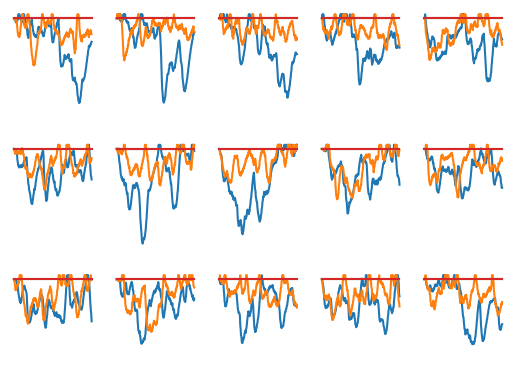

In [9]:
import torch
mem = torch.cat(results['Hybrid_RNN_SNN_V1_same_layer_rec_True']['history.pkl']['test']['voltage_tensors'], dim=1)  # concat on batch dim
spk = torch.cat(results['Hybrid_RNN_SNN_V1_same_layer_rec_True']['history.pkl']['test']['spike_tensors'], dim=1)
plot_voltage_traces(mem, spk)

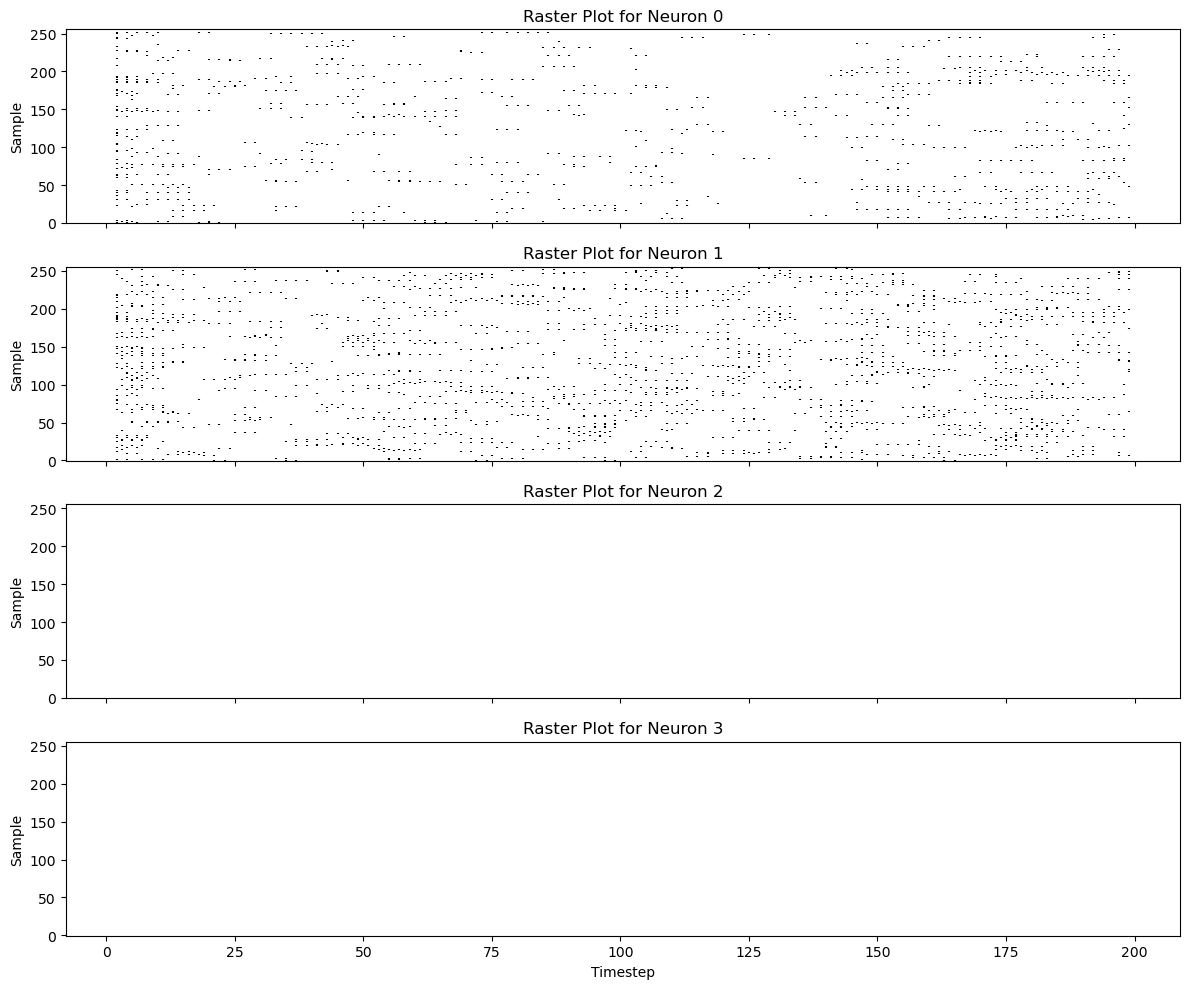

torch.Size([256, 200, 4])

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

for neuron_idx in range(4):
    ax = axs[neuron_idx]
    spikes = spk[:, :, neuron_idx]  # shape: [256, 200]
    for sample in range(spikes.shape[0]):
        spike_times = np.where(spikes[sample] > 0)[0]
        ax.vlines(spike_times, sample - 0.5, sample + 0.5, color='black')
    ax.set_ylabel('Sample')
    ax.set_title(f'Raster Plot for Neuron {neuron_idx}')
    ax.set_ylim(-0.5, 255.5)

axs[-1].set_xlabel('Timestep')
plt.tight_layout()
plt.show()# Check to see if all neurons spike in a given timestep
spk.shape

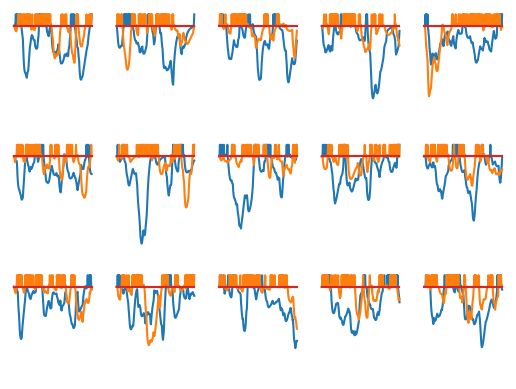

In [11]:
mem = torch.cat(results['Hybrid_RNN_SNN_rec_rec_False']['history.pkl']['test']['voltage_tensors'], dim=1)  # concat on batch dim
spk = torch.cat(results['Hybrid_RNN_SNN_rec_rec_False']['history.pkl']['test']['spike_tensors'], dim=1)
plot_voltage_traces(mem, spk)

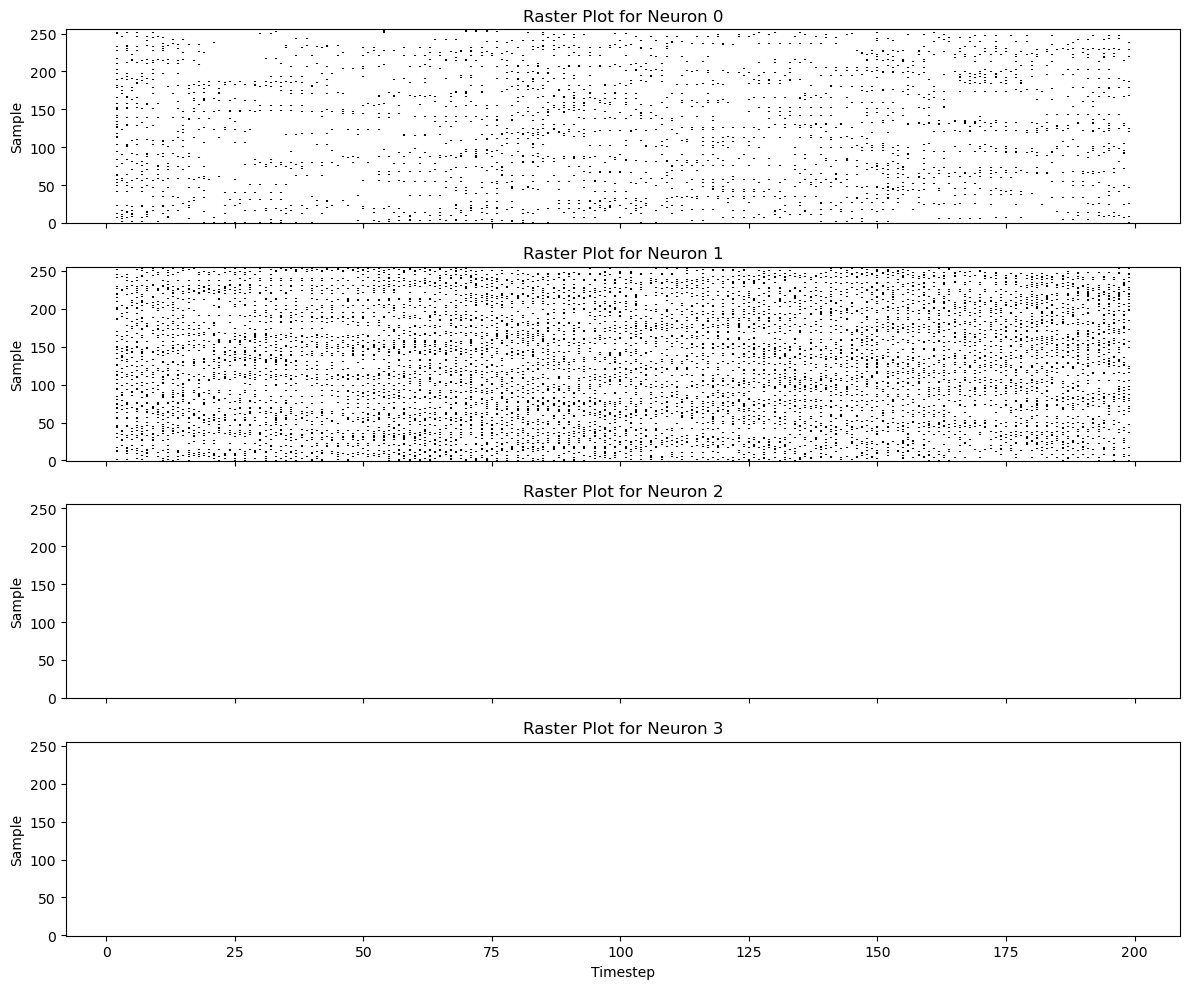

torch.Size([256, 200, 4])

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

for neuron_idx in range(4):
    ax = axs[neuron_idx]
    spikes = spk[:, :, neuron_idx]  # shape: [256, 200]
    for sample in range(spikes.shape[0]):
        spike_times = np.where(spikes[sample] > 0)[0]
        ax.vlines(spike_times, sample - 0.5, sample + 0.5, color='black')
    ax.set_ylabel('Sample')
    ax.set_title(f'Raster Plot for Neuron {neuron_idx}')
    ax.set_ylim(-0.5, 255.5)

axs[-1].set_xlabel('Timestep')
plt.tight_layout()
plt.show()# Check to see if all neurons spike in a given timestep
spk.shape

In [13]:
import matplotlib.pyplot as plt
best_results = {}
for model in remapping:
    print(model)
    config = results[model]['config.json']
    validation_accuracy = results[model]['history.pkl']['val']['acc'][-1]
    test_accuracy = results[model]['history.pkl']['test']['acc']
    recurrent_status = config['recurrent_setting']
    regularization = 'reg'
    final_name = remapping[model]
    total_spikes = results[model]['history.pkl']['test']['total_spikes']
    ann_cost, snn_cost = compute_cost(model, total_spikes)
    loss_surface = results[model]['3d_loss_surface.png']

    best_results[final_name] = {
        'train_accuracy': results[model]['history.pkl']['train']['acc'][-1],
        'val_accuracy': results[model]['history.pkl']['val']['acc'][-1],
        'test_accuracy': results[model]['history.pkl']['test']['acc'],
        'hyperparameters': {
            "l1_upper": config['l1_upper'],
            "v1_upper": config['v1_upper'],
            "l2_upper": config['l2_upper'],
            "v2_upper": config['v2_upper']
            },
        'total_spikes': total_spikes,
        'ann_cost': ann_cost,
        'snn_cost': snn_cost,
        'loss_landscape': loss_surface,

        # 'test_spikes': results[model]['history.pkl']['test']['total_spikes'],
        # 'test_voltage': results[model]['history.pkl']['train']['total_spikes'],
    }


model_names = list(best_results.keys())
validation_accuracies = [best_results[model]['val_accuracy'] for model in model_names]
test_accuracies = [best_results[model]['test_accuracy'] for model in model_names]
total_spikes_list = [best_results[model]['total_spikes'] for model in model_names]
ann_costs_list = [best_results[model]['ann_cost'] for model in model_names]
snn_costs_list = [best_results[model]['snn_cost'] for model in model_names]

for model in model_names:
    print(f"- {model}:")
    print(f"  Validation Accuracy: {best_results[model]['val_accuracy']}")
    print(f"  Test Accuracy: {best_results[model]['test_accuracy']}")
    print(f"  Hyperparameters: {best_results[model]['hyperparameters']}")
    print(f"  Average Spikes: {best_results[model]['total_spikes']}")
    print(f"  ANN Cost: {best_results[model]['ann_cost']:.2f}")
    print(f"  SNN Cost: {best_results[model]['snn_cost']:.2f}")


SNN_rec_False
SNN_rec_True
ANN_with_LIF_output_rec_False
ANN_with_LIF_output_rec_True
Hybrid_RNN_SNN_rec_rec_False
Hybrid_RNN_SNN_rec_rec_True
Hybrid_RNN_SNN_V1_same_layer_rec_True
- SNN:
  Validation Accuracy: 0.99609375
  Test Accuracy: 0.99609375
  Hyperparameters: {'l1_upper': 3, 'v1_upper': 3, 'l2_upper': 1, 'v2_upper': 1}
  Average Spikes: 19557
  ANN Cost: 0.00
  SNN Cost: 38.20
- Recurrent SNN:
  Validation Accuracy: 0.99609375
  Test Accuracy: 0.9921875
  Hyperparameters: {'l1_upper': 1, 'v1_upper': 2, 'l2_upper': 1, 'v2_upper': 1}
  Average Spikes: 27002
  ANN Cost: 0.00
  SNN Cost: 54.85
- ANN:
  Validation Accuracy: 1.0
  Test Accuracy: 0.96875
  Hyperparameters: {'l1_upper': 4, 'v1_upper': 0, 'l2_upper': 0, 'v2_upper': 2}
  Average Spikes: 0
  ANN Cost: 800.00
  SNN Cost: 0.00
- RNN:
  Validation Accuracy: 0.86328125
  Test Accuracy: 0.84765625
  Hyperparameters: {'l1_upper': 3, 'v1_upper': 5, 'l2_upper': 0, 'v2_upper': 0}
  Average Spikes: 0
  ANN Cost: 832.00
  SNN Cost:

In [14]:
import matplotlib.pyplot as plt
import numpy as np



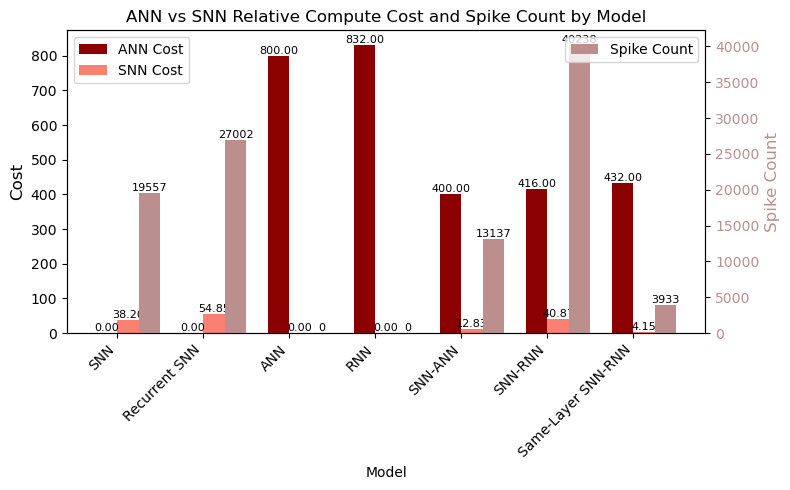

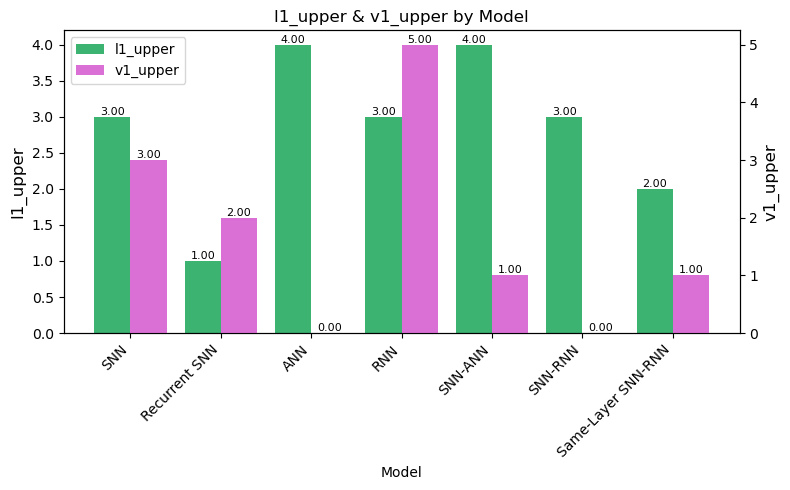

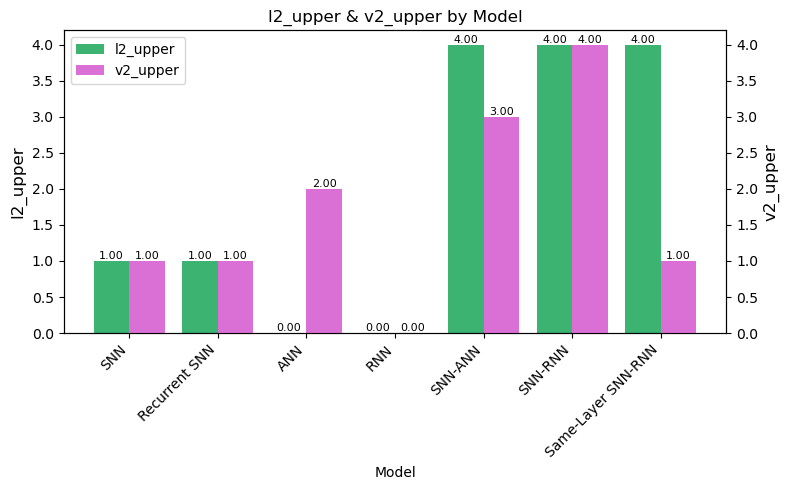

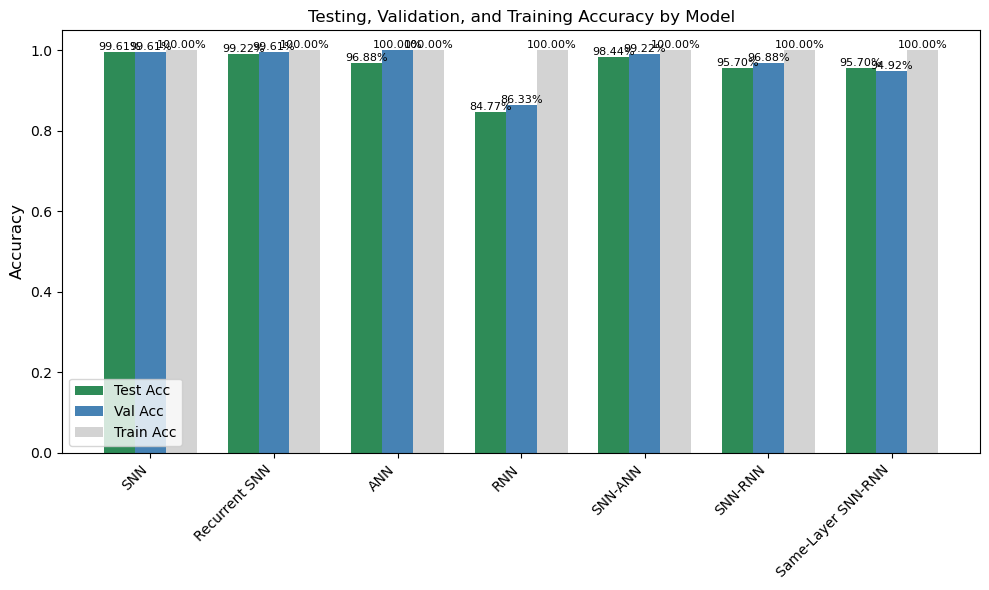

In [15]:
import matplotlib.pyplot as plt


model_names = list(best_results.keys())

# --- Dual-Axis Cost Plot (ANN vs SNN) --- -> EVENTUALLY ADJUST SO IT'S THE SAME AXIS
import matplotlib.pyplot as plt


model_names = list(best_results.keys())

def plot_costs_same_axis(best_results, show_total=False):
    model_names = list(best_results.keys())
    ann_vals = [best_results[m]['ann_cost'] for m in model_names]
    snn_vals = [best_results[m]['snn_cost'] for m in model_names]
    spike_counts = [best_results[m]['total_spikes'] for m in model_names]  # Assuming 'spike_count' is in best_results

    fig, ax1 = plt.subplots(figsize=(8, 5))
    width = 0.25
    x = np.arange(len(model_names))  # Use numpy for easier bar positioning

    # Plot ANN and SNN bars side-by-side on the primary axis (ax1)
    bars1 = ax1.bar(x - width, ann_vals, width=width, label='ANN Cost', color='darkred')
    bars2 = ax1.bar(x, snn_vals, width=width, label='SNN Cost', color='salmon')

    ax1.set_ylabel('Cost', fontsize=12, color='black')
    ax1.set_xticks(x - width/2)  # Adjust x-ticks to be centered
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.set_xlabel('Model')
    ax1.set_title('ANN vs SNN Relative Compute Cost and Spike Count by Model')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.legend(loc='upper left')

    # Create a secondary axis (ax2) for spike counts
    ax2 = ax1.twinx()
    bars3 = ax2.bar(x + width, spike_counts, width=width, label='Spike Count', color='rosybrown')
    ax2.set_ylabel('Spike Count', fontsize=12, color='rosybrown')
    ax2.tick_params(axis='y', labelcolor='rosybrown')
    ax2.legend(loc='upper right')

    # Add numeric labels on bars (for ANN and SNN)
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    # Add numeric labels on bars (for Spike Counts)
    for bar in bars3:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color='black')

    if show_total:
        total_vals = [a + s for a, s in zip(ann_vals, snn_vals)]
        for i, total in enumerate(total_vals):
            ax1.text(x[i] - width/2, max(ann_vals[i], snn_vals[i]) + 0.05 * max(total_vals), f'Total: {total:.2f}', ha='center', va='bottom', fontsize=9, color='black')

    plt.tight_layout()
    plt.show()

# --- Hyperparameter Dual-Axis Plot ---
def plot_hyperparam_dual_axis(param1, param2):
    vals1 = [best_results[m]['hyperparameters'][param1] for m in model_names]
    vals2 = [best_results[m]['hyperparameters'][param2] for m in model_names]

    fig, ax1 = plt.subplots(figsize=(8, 5))
    width = 0.4
    x = range(len(model_names))

    bars1 = ax1.bar([i - width/2 for i in x], vals1, width=width, label=param1, color='mediumseagreen')
    ax1.set_ylabel(param1, fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.set_xlabel('Model')

    ax2 = ax1.twinx()
    bars2 = ax2.bar([i + width/2 for i in x], vals2, width=width, label=param2, color='orchid')
    ax2.set_ylabel(param2, fontsize=12)

    # Add labels
    for bar in bars1:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=8)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax1.set_title(f'{param1} & {param2} by Model')
    plt.tight_layout()
    plt.show()

# --- Accuracy Plot ---
def plot_accuracies(best_results):
    test_vals = [best_results[m]['test_accuracy'] for m in model_names]
    val_vals   = [best_results[m]['val_accuracy']   for m in model_names]

    fig, ax = plt.subplots(figsize=(8, 5))
    width = 0.35
    x = range(len(model_names))

    bars1 = ax.bar([i - width/2 for i in x], test_vals, width=width, label='Test Acc', color='seagreen')
    bars2 = ax.bar([i + width/2 for i in x], val_vals,   width=width, label='Val Acc',   color='steelblue')

    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Testing vs Validation Accuracy by Model')

    # Add labels
    for bar in bars1:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()*100:.1f}%', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()*100:.1f}%', ha='center', va='bottom', fontsize=8)

    ax.legend()
    plt.tight_layout()
    plt.show()

# --- Hyperparameter Dual-Axis Plot ---
def plot_hyperparam_dual_axis(param1, param2):
    vals1 = [best_results[m]['hyperparameters'][param1] for m in model_names]
    vals2 = [best_results[m]['hyperparameters'][param2] for m in model_names]

    fig, ax1 = plt.subplots(figsize=(8, 5))
    width = 0.4
    x = range(len(model_names))

    bars1 = ax1.bar([i - width/2 for i in x], vals1, width=width, label=param1, color='mediumseagreen')
    ax1.set_ylabel(param1, fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.set_xlabel('Model')

    ax2 = ax1.twinx()
    bars2 = ax2.bar([i + width/2 for i in x], vals2, width=width, label=param2, color='orchid')
    ax2.set_ylabel(param2, fontsize=12)

    # Add labels
    for bar in bars1:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=8)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax1.set_title(f'{param1} & {param2} by Model')
    plt.tight_layout()
    plt.show()

# --- Accuracy Plot ---
def plot_accuracies(best_results):
    model_names = list(best_results.keys())
    test_vals = [best_results[m]['test_accuracy'] for m in model_names]
    val_vals   = [best_results[m]['val_accuracy']   for m in model_names]
    train_vals = [best_results[m]['train_accuracy']  for m in model_names] # Added train accuracy

    fig, ax = plt.subplots(figsize=(10, 6)) # Increased figure size for better readability
    width = 0.25 # Adjusted bar width to accommodate three bars
    x = np.arange(len(model_names)) # Using numpy for easier bar positioning

    bars1 = ax.bar(x - width, test_vals, width=width, label='Test Acc', color='seagreen')
    bars2 = ax.bar(x,         val_vals,   width=width, label='Val Acc',   color='steelblue')
    bars3 = ax.bar(x + width, train_vals, width=width, label='Train Acc', color='lightgrey') # Added train accuracy bar

    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Testing, Validation, and Training Accuracy by Model')

    # Add labels
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height, f'{height*100:.2f}%', ha='center', va='bottom', fontsize=8)

    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)

    ax.legend()
    plt.tight_layout()
    plt.show()

# Execute plots
plot_costs_same_axis(best_results, show_total=False)
plot_hyperparam_dual_axis('l1_upper', 'v1_upper')
plot_hyperparam_dual_axis('l2_upper', 'v2_upper')
plot_accuracies(best_results)
# Now let's add the other visualizations


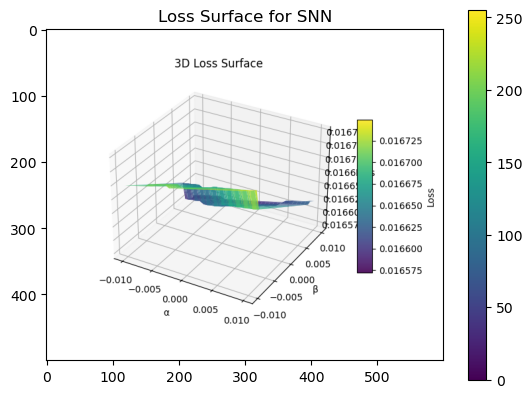

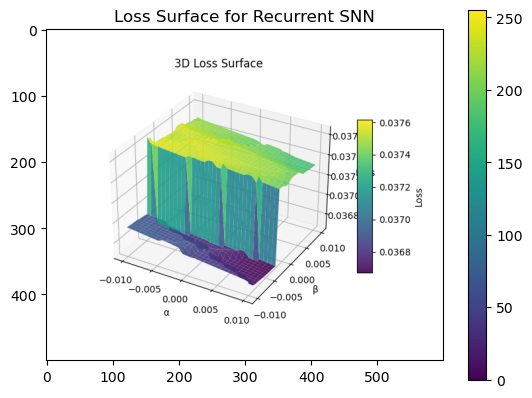

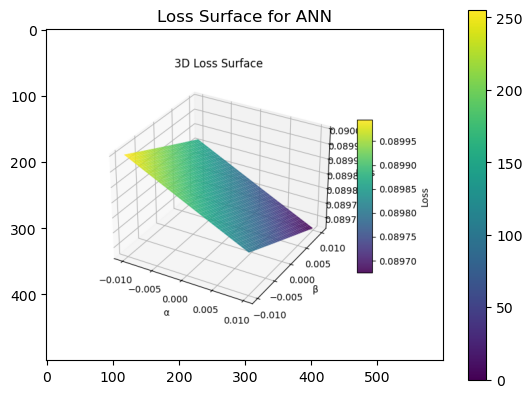

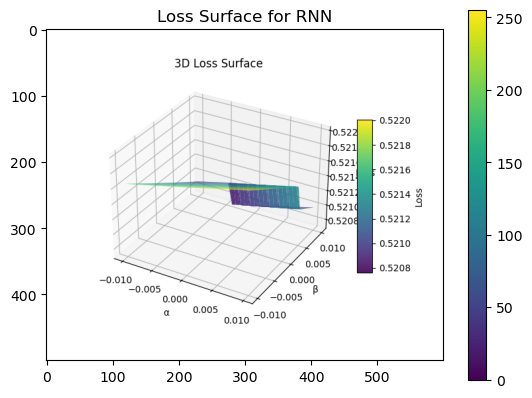

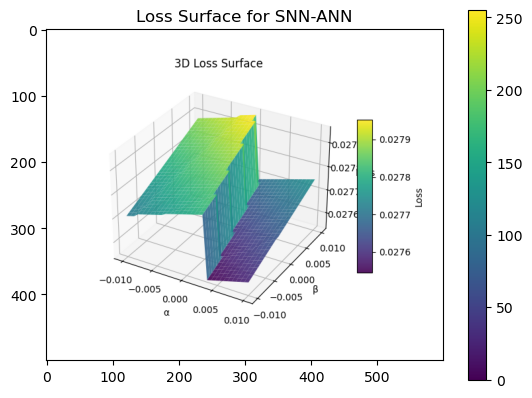

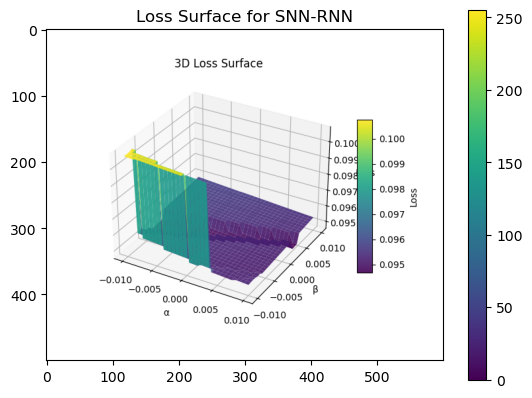

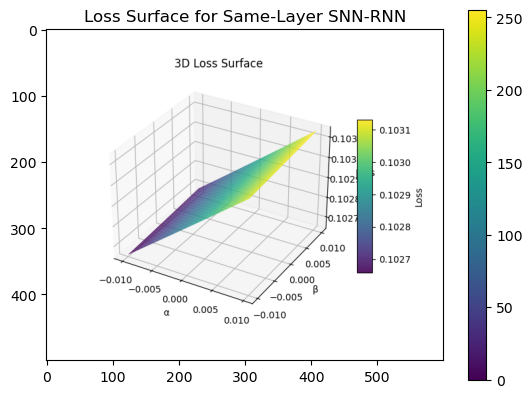

In [16]:
# Show saved loss surface images
for model in best_results:
    loss_surface = best_results[model]['loss_landscape']
    plt.imshow(loss_surface)
    plt.title(f'Loss Surface for {model}')
    plt.colorbar()
    plt.show()

In [17]:
results['ANN_with_LIF_output_rec_True']['history.pkl']['test']

{'loss': 0.5214569568634033,
 'acc': 0.84765625,
 'spikes_per_t': [],
 'total_spikes': 0,
 'spike_tensors': [],
 'voltage_tensors': []}